# SVD Unfolder (with ROOT)

Based on the SVD example taken from [ROOT's TSVDUnfoldExample](https://root.cern/doc/master/TSVDUnfoldExample_8C.html).

In [5]:
import example
import ROOT
import numpy as np
import math
%matplotlib inline

## Initialization
Generate data

In [2]:
# toy generation
nbins = 40
# Generate initial distribution and response matrix
xini, bini, Adet = example.maker.generate_initial_samples(nbins)
# Generate test distribution (what is measured in the experiment)
datatrue, data, statcov = example.maker.generate_test_samples(nbins)

## Unfolding

In [6]:
# ----------------------------
# Here starts the actual unfolding
#
# Create TSVDUnfold object and initialise
tsvdunf = ROOT.TSVDUnfold(data, statcov, bini, xini, Adet)

# It is possible to normalise unfolded spectrum to unit area
tsvdunf.SetNormalize(ROOT.kFALSE)  # no normalisation here

# Perform the unfolding with regularisation parameter kreg = 13
# - the larger kreg, the finer grained the unfolding, but the more fluctuations occur
# - the smaller kreg, the stronger is the regularisation and the bias
unfres = tsvdunf.Unfold(13)

# Get the distribution of the d to cross check the regularization
# - choose kreg to be the point where |d_i| stop being statistically significantly >>1
ddist = tsvdunf.GetD()

# Get the distribution of the singular values
svdist = tsvdunf.GetSV()

# Compute the error matrix for the unfolded spectrum using toy MC
# using the measured covariance matrix as input to generate the toys
# 100 toys should usually be enough
# The same method can be used for different covariance matrices separately.
ustatcov = tsvdunf.GetUnfoldCovMatrix(statcov, 100)

# Now compute the error matrix on the unfolded distribution originating
# from the finite detector matrix statistics
uadetcov = tsvdunf.GetAdetCovMatrix(100)

# Sum up the two (they are uncorrelated)
ustatcov.Add(uadetcov)

# Get the computed regularized covariance matrix (always corresponding to total uncertainty passed in constructor) and add uncertainties from finite MC statistics.
utaucov = tsvdunf.GetXtau()
utaucov.Add(uadetcov)

# Get the computed inverse of the covariance matrix
uinvcov = tsvdunf.GetXinv()

Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.002960


# Plot the results

In [7]:
# Only plotting stuff below
for i in range(1, unfres.GetNbinsX() + 1):
    unfres.SetBinError(i, math.sqrt(utaucov.GetBinContent(i, i)))

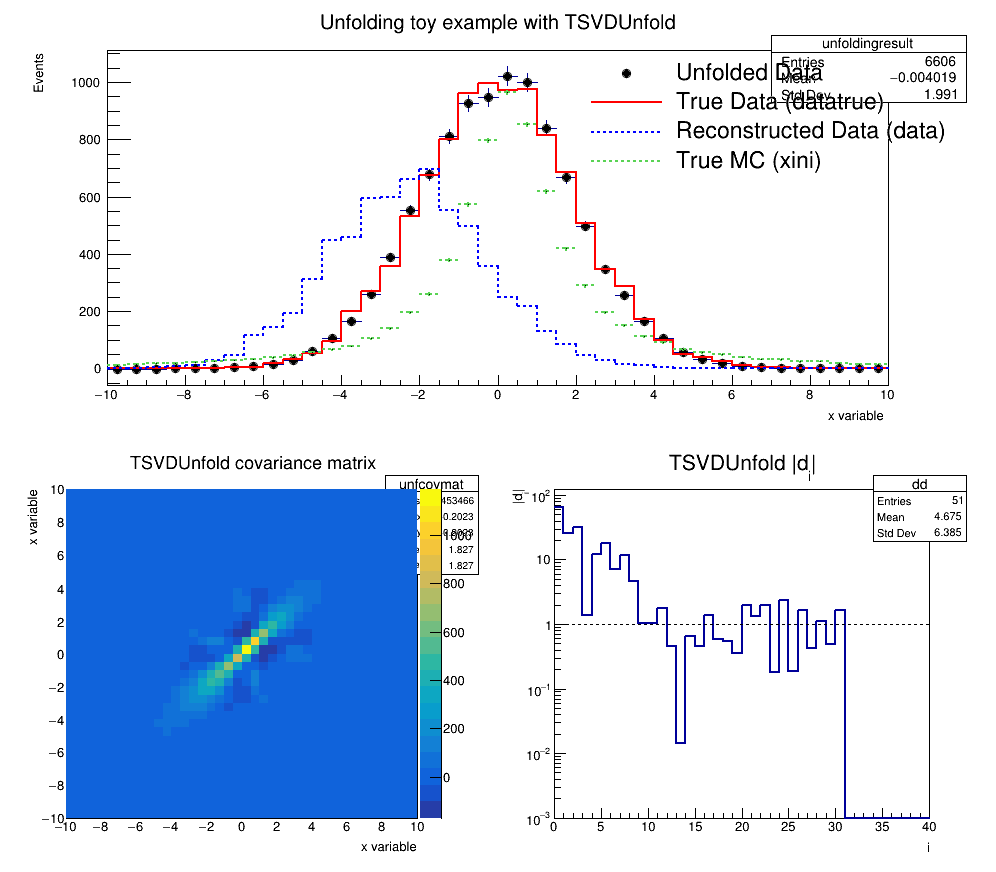

In [8]:
# Renormalize just to be able to plot on the same scale
xini.Scale(0.7 * datatrue.Integral() / xini.Integral())

leg = ROOT.TLegend(0.58, 0.60, 0.99, 0.88)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.AddEntry(unfres, "Unfolded Data", "p")
leg.AddEntry(datatrue, "True Data (datatrue)", "l")
leg.AddEntry(data, "Reconstructed Data (data)", "l")
leg.AddEntry(xini, "True MC (xini)", "l")

c1 = ROOT.TCanvas("c1", "Unfolding toy example with TSVDUnfold", 1000, 900)

c1.Divide(1, 2)
c11 = c1.cd(1)

frame = ROOT.TH1D(unfres)
frame.SetTitle("Unfolding toy example with TSVDUnfold")
frame.GetXaxis().SetTitle("x variable")
frame.GetYaxis().SetTitle("Events")
frame.GetXaxis().SetTitleOffset(1.25)
frame.GetYaxis().SetTitleOffset(1.29)
frame.Draw()

data.SetLineStyle(2)
data.SetLineColor(4)
data.SetLineWidth(2)
unfres.SetMarkerStyle(20)
datatrue.SetLineColor(2)
datatrue.SetLineWidth(2)
xini.SetLineStyle(2)
xini.SetLineColor(8)
xini.SetLineWidth(2)
# ------------------------------------------------------------

# add histograms
unfres.Draw("same")
datatrue.Draw("same")
data.Draw("same")
xini.Draw("same")

leg.Draw()

# covariance matrix
c12 = c1.cd(2)
c12.Divide(2, 1)
c2 = c12.cd(1)
c2.SetRightMargin(0.15)

covframe = ROOT.TH2D(ustatcov)
covframe.SetTitle("TSVDUnfold covariance matrix")
covframe.GetXaxis().SetTitle("x variable")
covframe.GetYaxis().SetTitle("x variable")
covframe.GetXaxis().SetTitleOffset(1.25)
covframe.GetYaxis().SetTitleOffset(1.29)
covframe.Draw()

ustatcov.SetLineWidth(2)
ustatcov.Draw("colzsame")

# distribution of the d quantity
c3 = c12.cd(2)
c3.SetLogy()

line = ROOT.TLine(0.0, 1.0, 40.0, 1.0)
line.SetLineStyle(2)

dframe = ROOT.TH1D(ddist)
dframe.SetTitle("TSVDUnfold |d_{i}|")
dframe.GetXaxis().SetTitle("i")
dframe.GetYaxis().SetTitle("|d_{i}|")
dframe.GetXaxis().SetTitleOffset(1.25)
dframe.GetYaxis().SetTitleOffset(1.29)
dframe.SetMinimum(0.001)
dframe.Draw()

ddist.SetLineWidth(2)
ddist.Draw("same")
line.Draw()
c1.Draw()

### NOTA: "True MC" está re-escalado para que quepa en la gráfica! En realidad, es mucho más alta
### NOTA: unfoldSVD hace un escalamiento natural

De https://root.cern/root/html532/TSVDUnfold.html :
> `kreg` determines the regularisation of the unfolding. In general, overregularisation (too small `kreg`) will bias the unfolded spectrum towards the Monte Carlo input, while underregularisation (too large `kreg`) will lead to large fluctuations in the unfolded spectrum